# Setup

## Imports

In [ ]:
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

import pickle
import time
from functools import partial
from typing import List, Tuple

import diffrax
import equinox as eqx
import evosax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from adaptive import Learner1D, Learner2D
from adaptive.notebook_integration import notebook_extension
from IPython.display import clear_output
from jaxtyping import Array, ArrayLike, PRNGKeyArray, PyTree, Scalar

import optimal_control.constraints as constraints
import optimal_control.controls as controls
import optimal_control.environments.examples as examples
import optimal_control.nn as nn
import optimal_control.solvers as solvers
import optimal_control.trainers as trainers

In [ ]:
notebook_extension()

In [68]:
a4_inches = (8.3, 11.7)
plot_full_width = a4_inches[0]
plot_half_width = a4_inches[0] / 2
plot_third_width = a4_inches[0] / 3
plot_quarter_width = a4_inches[0] / 4

result_base_dir = "../thesis-results/apoptosis"
plot_style = "seaborn-paper"

plot_shrink_factor = 0.9

plt.style.use(plot_style)

/tmp/ipykernel_10800/1812576562.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(plot_style)


## General definitions

In [146]:
# Random key for reproducibility
key = jax.random.PRNGKey(1234)

# Initialize environment
environment: examples.ApoptosisEnvironment = examples.ApoptosisEnvironment(
    "../data/Initial_concentrations_CD95H_wtH.mat", [0, 500], 50
)
environment_state = environment.init()

eval_environment: examples.ApoptosisEnvironment = examples.ApoptosisEnvironment(
    "../data/Initial_concentrations_CD95H_wtH.mat", [500, 1000], -1, True
)
eval_environment_state = eval_environment.init()

# Build controller
key, subkey = jax.random.split(key)
control = controls.ImplicitTemporalControl(
    implicit_fn=nn.Siren(
        in_features=1, out_features=1, hidden_features=64, hidden_layers=2, key=subkey
    ),
    t_start=0.0,
    t_end=180.0,
    to_curve=True,
    curve_interpolation="linear",
    curve_steps=181,
)


def tbid_fraction(ys: Array) -> Array:
    return ys[..., 12] / (ys[..., 3] + ys[..., 12])


# Define reward function
def proxy_reward_fn(
    args: Tuple[diffrax.Solution, Array], instantaneous: bool = False, norm: bool = True
):
    # Continuous fraction of tBID, clipped at the tBID-apoptosis threshold

    solution, thresh = args
    ys = solution.ys

    tBID_frac = ys[..., 12] / (ys[..., 3] + ys[..., 12])
    if norm:
        frac_norm = tBID_frac / thresh
        frac_clipped = jnp.clip(frac_norm, a_max=1.0)
    else:
        frac_clipped = jnp.clip(tBID_frac, a_max=thresh)

    if instantaneous:
        reward = jnp.sum(frac_clipped, axis=-1)
    else:
        reward = jnp.mean(jnp.sum(frac_clipped, axis=-1))

    return reward


def true_reward_fn(args: Tuple[diffrax.Solution, Array], instantaneous: bool = False):
    # Number of dead cells

    solution, thresh = args
    ys = solution.ys

    tBID_frac = ys[..., 12] / (ys[..., 3] + ys[..., 12])
    tBID_above = tBID_frac > thresh

    if instantaneous:
        reward = jnp.sum(tBID_above, axis=-1)
    else:
        reward = jnp.mean(jnp.sum(tBID_above, axis=-1))

    return reward


# Direct solver
direct_solver = solvers.DirectSolver(optax.adam(learning_rate=3e-4))


# ES Solver factory (to allow for init parameters)
def make_es_solver(init_control: controls.AbstractControl) -> solvers.ESSolver:
    evo_control_params = eqx.filter(init_control, eqx.is_array)
    evo_parameter_reshaper = evosax.ParameterReshaper(evo_control_params)
    evo_fitness_shaper = evosax.FitnessShaper(centered_rank=True, maximize=True)

    # """
    evo_strategy = evosax.OpenES(
        popsize=64,
        lrate_init=3e-4,
        lrate_limit=3e-4,
        sigma_init=1e-3,
        sigma_limit=1e-3,
        num_dims=len(evo_parameter_reshaper.flatten_single(evo_control_params)),
    )
    # """

    """
    evo_strategy = evosax.LES(
        popsize=64,
        num_dims=len(evo_parameter_reshaper.flatten_single(evo_control_params)),
        net_ckpt_path="../data/2023_03_les_v1.pkl",
    )
    """

    evo_strategy_params = evo_strategy.default_params

    evo_solver: solvers.ESSolver = solvers.ESSolver(
        evo_strategy, evo_strategy_params, evo_parameter_reshaper, evo_fitness_shaper
    )

    return evo_solver

In [ ]:
# Training helper
@eqx.filter_jit
def train_with_integral(
    control: controls.AbstractControl,
    solver: solvers.AbstractSolver,
    target_integral: Array,
    reward_fn=proxy_reward_fn,
    num_steps: int = 1024,
) -> Tuple[Scalar, controls.AbstractControl]:
    constraint_chain = constraints.ConstraintChain(
        transformations=[
            constraints.NonNegativeConstantIntegralConstraint(target=target_integral)
        ]
    )

    opt_reward, opt_control = trainers.solve_optimal_control_problem(
        num_train_steps=num_steps,
        environment=environment,
        reward_fn=reward_fn,
        constraint_chain=constraint_chain,
        solver=solver,
        control=control,
        key=key,
        pbar_interval=8,
        integrate_kwargs=dict(vmap="inner"),
    )

    return opt_reward, opt_control


@eqx.filter_jit
def evaluate_with_integral(
    control: controls.AbstractControl,
    target_integral: Array,
    environment: examples.ApoptosisEnvironment,
    state: examples.ApoptosisState,
) -> Tuple[PyTree, controls.AbstractControl]:
    constraint_chain = constraints.ConstraintChain(
        transformations=[
            constraints.NonNegativeConstantIntegralConstraint(target=target_integral)
        ]
    )

    constrained_control, _ = solvers.build_control(control, constraint_chain)

    solution = environment.integrate(constrained_control, state, key, vmap="inner")
    return solution, constrained_control

In [ ]:
import base64
import io
import json
from typing import Any
import dataclasses


class JaxSONEncoder(json.JSONEncoder):
    def default(self, o: Any) -> Any:
        if dataclasses.is_dataclass(o):
            return {
                "__dataclass__": True,
                "__class_name__": o.__class__.__module__
                + "."
                + o.__class__.__qualname__,
                "fields": dataclasses.asdict(o),
            }

        if isinstance(o, Array):
            # Convert to numpy array
            o = np.asarray(o)

            # Save to memory
            buffer = io.BytesIO()
            jnp.save(buffer, o, allow_pickle=False)

            # Convert the numpy array to a base64 encoded string
            data = base64.b64encode(buffer.getvalue()).decode("utf-8")

            # Include type annotation and return data
            return {"__numpy_array__": True, "data": data}

        # For other types, use the default encoder
        return super().default(o)


class JaxSONDecoder(json.JSONDecoder):
    def __init__(self, dataclass_lookup: dict[str, Any], *args, **kwargs):
        super().__init__(object_hook=self.object_hook, *args, **kwargs)

        self.dataclass_lookup = dataclass_lookup

    def object_hook(self, o: Any) -> Any:
        if "__dataclass__" in o:
            # Construct class instance with __new__
            # This allows us to avoid calling __init__, which might be overridden
            dataclass_class = self.dataclass_lookup[o["__class_name__"]]
            dataclass_instance = dataclass_class.__new__(dataclass_class)

            # Replace currently undefined fields with saved fields
            dataclass_instance = dataclasses.replace(dataclass_instance, **o["fields"])
            return dataclass_instance

            # eqx.tree_at(lambda pytree: jax.tree_util.tree_flatten(pytree)[0], dataclass_instance, )

        if "__numpy_array__" in o:
            # Decode the base64 encoded data
            data = base64.b64decode(o["data"])

            # Load the numpy array
            buffer = io.BytesIO(data)
            return jnp.load(buffer)

        return o

# Run

## Comparison between grad, es, and rewards

### Train networks

In [ ]:
pretrained_reward, pretrained_control = train_with_integral(
    control,
    direct_solver,
    jnp.asarray([1.0]),
    reward_fn=proxy_reward_fn,
    num_steps=1024,
)

In [ ]:
finetuned_reward, finetuned_control = train_with_integral(
    pretrained_control,
    make_es_solver(pretrained_control),
    jnp.asarray([1.0]),
    reward_fn=true_reward_fn,
    num_steps=256,
)

In [ ]:
only_es_reward, only_es_control = train_with_integral(
    control,
    make_es_solver(pretrained_control),
    jnp.asarray([1.0]),
    reward_fn=true_reward_fn,
    num_steps=1024 + 256,
)

### Evaluate solutions

In [ ]:
(pretrain_solution, tBID_thresh), pretrain_constrained_control = evaluate_with_integral(
    pretrained_control, jnp.asarray([1.0]), eval_environment, eval_environment_state
)

(
    finetuned_solution,
    tBID_thresh,
), finetune_constrained_control = evaluate_with_integral(
    finetuned_control, jnp.asarray([1.0]), eval_environment, eval_environment_state
)

(
    only_es_solution,
    tBID_thresh,
), only_es_constrained_control = evaluate_with_integral(
    only_es_control, jnp.asarray([1.0]), eval_environment, eval_environment_state
)

In [ ]:
pretrain_proxy_reward = proxy_reward_fn(
    (pretrain_solution, tBID_thresh), instantaneous=True
)
pretrain_true_reward = true_reward_fn(
    (pretrain_solution, tBID_thresh), instantaneous=True
)

finetune_proxy_reward = proxy_reward_fn(
    (finetuned_solution, tBID_thresh), instantaneous=True
)
finetune_true_reward = true_reward_fn(
    (finetuned_solution, tBID_thresh), instantaneous=True
)

only_es_proxy_reward = proxy_reward_fn(
    (only_es_solution, tBID_thresh), instantaneous=True
)
only_es_true_reward = true_reward_fn(
    (only_es_solution, tBID_thresh), instantaneous=True
)

In [ ]:
print(jnp.mean(pretrain_true_reward), jnp.mean(finetune_true_reward))
print(pretrain_true_reward[-1], finetune_true_reward[-1])

### Save solutions

In [ ]:
eqx.tree_serialise_leaves(
    result_base_dir + "/reward_comparison/pretrain_control.eqx", pretrained_control
)
eqx.tree_serialise_leaves(
    result_base_dir + "/reward_comparison/finetune_control.eqx", finetuned_control
)
eqx.tree_serialise_leaves(
    result_base_dir + "/reward_comparison/es_control.eqx", only_es_control
)

### Plot solutions

In [ ]:
ts = pretrain_solution.ts

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(plot_half_width, plot_half_width))

ax[0].set_ylabel("True Reward")
ax[0].plot(ts, pretrain_true_reward, label="Proxy")
ax[0].plot(ts, finetune_true_reward, linestyle="--", label="Proxy -> True")
ax[0].plot(ts, only_es_true_reward, label="True")
ax[0].legend()

ax[1].set_xlabel("Time [min.]")
ax[1].set_ylabel("Proxy Reward")
ax[1].plot(ts, pretrain_proxy_reward, label="Proxy")
ax[1].plot(ts, finetune_proxy_reward, linestyle="--", label="Proxy -> True")
ax[1].plot(ts, only_es_proxy_reward, label="True")

plt.savefig(
    result_base_dir + "/reward_comparison/proxy_and_true_reward.png",
    bbox_inches="tight",
)
plt.savefig(
    result_base_dir + "/reward_comparison/proxy_and_true_reward.svg",
    bbox_inches="tight",
)

plt.show()

In [ ]:
ts = pretrain_solution.ts
p_cs = jax.vmap(pretrain_constrained_control)(ts)
f_cs = jax.vmap(finetune_constrained_control)(ts)
es_cs = jax.vmap(only_es_constrained_control)(ts)

In [ ]:
plt.figure(figsize=(plot_half_width, plot_half_width))

plt.xlabel("Time [min.]")
plt.ylabel("CD95L [ng/ml]")
plt.plot(ts, p_cs, label="Proxy")
plt.plot(ts, f_cs, linestyle="--", label="Proxy -> True")
plt.plot(ts, es_cs, label="True")
plt.legend()

plt.savefig(
    result_base_dir + "/reward_comparison/proxy_and_true_controls.png",
    bbox_inches="tight",
)
plt.savefig(
    result_base_dir + "/reward_comparison/proxy_and_true_controls.svg",
    bbox_inches="tight",
)

plt.show()

### Show loss landscapes

In [ ]:
# Evaluate region around optimum


@eqx.filter_jit
def sample_direction(network: PyTree, key: PRNGKeyArray) -> PyTree:
    jax_params = eqx.filter(network, eqx.is_array)
    reshaper = evosax.ParameterReshaper(eqx.filter(network, eqx.is_array))
    flat_params = reshaper.flatten_single(jax_params)
    noise = jax.random.normal(key, flat_params.shape, flat_params.dtype)
    direction = noise / jnp.sqrt(jnp.sum(jnp.square(noise)))

    return direction


@eqx.filter_jit
def scan_2d(
    control: controls.AbstractControl, x: Array, y: Array, xs: Array, ys: Array
):
    jax_params, jax_static = eqx.partition(control, eqx.is_array)
    reshaper = evosax.ParameterReshaper(jax_params)
    source_params = reshaper.flatten_single(jax_params)
    offsets = y[None, None] * ys[:, None, None] + x[None, None] * xs[None, :, None]
    offsets = offsets.reshape(-1, len(source_params))
    grid_params = source_params + offsets

    # """
    grid_controls = eqx.combine(reshaper.reshape(grid_params), jax_static)

    (
        grid_solutions,
        grid_tbid_thresholds,
    ), _ = eqx.filter_vmap(
        partial(
            evaluate_with_integral,
            target_integral=jnp.asarray([1.0]),
            environment=eval_environment,
            state=eval_environment_state,
        )
    )(grid_controls)
    # """

    """
    grid_controls = eqx.combine(reshaper.reshape(grid_params), jax_static)
    grid_solutions, grid_tBID_thresholds = jax.lax.map(
        partial(
            evaluate_with_integral,
            target_integral=jnp.asarray([1.0]),
            environment=eval_environment,
            state=eval_environment_state,
        ),
        grid_controls,
    )
    """

    """
    grid_solutions = []
    grid_tbid_thresholds = []
    for params in grid_params:
        grid_control = eqx.combine(reshaper.reshape_single(params), jax_static)
        grid_solution, grid_tbid_threshold = evaluate_with_integral(
            control=grid_control,
            target_integral=jnp.asarray([1.0]),
            environment=eval_environment,
            state=eval_environment_state,
        )

        grid_solutions.append(grid_solutions)
        grid_tbid_thresholds.append(grid_tbid_thresholds)

    grid_solutions = jax.tree_map(
        lambda x: jnp.stack(x, axis=0) if eqx.is_array(x[0]) else x[0],
        grid_solutions[0],
        grid_solutions[1:],
    )
    grid_tbid_thresholds = jnp.stack(grid_tbid_thresholds, axis=0)
    """

    return grid_solutions, grid_tbid_thresholds


@eqx.filter_jit
def sample_control(
    control: controls.AbstractControl, x_dir: Array, y_dir: Array, x: Scalar, y: Scalar
) -> controls.AbstractControl:
    jax_params, jax_static = eqx.partition(control, eqx.is_array)
    reshaper = evosax.ParameterReshaper(jax_params)
    source_params = reshaper.flatten_single(jax_params)

    offset = y_dir * y + x_dir * x
    offset_params = source_params + offset
    offset_params = reshaper.reshape_single(offset_params)
    offset_control = eqx.combine(offset_params, jax_static)

    return offset_control


def adaptive_2d(
    control: controls.AbstractControl,
    x_dir: Array,
    y_dir: Array,
    bounds: Tuple[float],
    reward_fn,
    max_points: int = 1204,
):
    learner = Learner2D(lambda _: 0.0, bounds=bounds)
    learner.stack_size = 1

    last_plt_time = time.time()
    plt_interval = 15

    while learner.npoints < max_points:
        try:
            points, _ = learner.ask(1)
            point = points[0]
            x, y = point

            offset_control = sample_control(
                control, x_dir, y_dir, jnp.float_(x), jnp.float_(y)
            )
            offset_solution, _ = evaluate_with_integral(
                offset_control,
                jnp.asarray([1.0]),
                eval_environment,
                eval_environment_state,
            )
            offset_reward = reward_fn(offset_solution)
            learner.tell(point, float(offset_reward))

            if time.time() - last_plt_time >= plt_interval:
                clear_output(wait=True)
                display(learner.plot(tri_alpha=0.25))
                last_plt_time = time.time()
        except KeyboardInterrupt:
            break

    return learner

In [ ]:
xkey, ykey = jax.random.split(key)

x = sample_direction(pretrained_control, xkey)
y = sample_direction(pretrained_control, ykey)

In [ ]:
# This consumes lots of RAM

grid_solutions, grid_tBID_thresholds = scan_2d(
    pretrained_control, x, y, jnp.linspace(-1.5, 1.5, 16), jnp.linspace(-1.5, 1.5, 16)
)

es_grid_solutions, es_grid_tBID_thresholds = scan_2d(
    only_es_control, x, y, jnp.linspace(-1.5, 1.5, 16), jnp.linspace(-1.5, 1.5, 16)
)

In [ ]:
pretrain_proxy_learner = adaptive_2d(
    pretrained_control,
    x,
    y,
    [(-1.5, 1.5), (-1.5, 1.5)],
    reward_fn=proxy_reward_fn,
    max_points=1024,
)

pretrain_true_learner = adaptive_2d(
    pretrained_control,
    x,
    y,
    [(-1.5, 1.5), (-1.5, 1.5)],
    reward_fn=true_reward_fn,
    max_points=1024,
)

In [ ]:
es_proxy_learner = adaptive_2d(
    only_es_control,
    x,
    y,
    [(-1.5, 1.5), (-1.5, 1.5)],
    reward_fn=proxy_reward_fn,
    max_points=1024,
)

es_true_learner = adaptive_2d(
    only_es_control,
    x,
    y,
    [(-1.5, 1.5), (-1.5, 1.5)],
    reward_fn=true_reward_fn,
    max_points=1024,
)

#### Save learners

In [ ]:
pretrain_proxy_learner.save(
    result_base_dir + "/reward_comparison/pretrain_proxy_learner.pickle"
)
pretrain_true_learner.save(
    result_base_dir + "/reward_comparison/pretrain_true_learner.pickle"
)
es_proxy_learner.save(result_base_dir + "/reward_comparison/es_proxy_learner.pickle")
es_true_learner.save(result_base_dir + "/reward_comparison/es_true_learner.pickle")

#### Plot from vmapped grids

In [ ]:
grid_proxy_rewards = eqx.filter_vmap(proxy_reward_fn)(
    (grid_solutions, grid_tBID_thresholds)
)
grid_proxy_no_norm_rewards = eqx.filter_vmap(partial(proxy_reward_fn, norm=False))(
    (grid_solutions, grid_tBID_thresholds)
)
grid_true_rewards = eqx.filter_vmap(true_reward_fn)(
    (grid_solutions, grid_tBID_thresholds)
)

es_grid_proxy_rewards = eqx.filter_vmap(proxy_reward_fn)(
    (grid_solutions, grid_tBID_thresholds)
)
es_grid_proxy_no_norm_rewards = eqx.filter_vmap(partial(proxy_reward_fn, norm=False))(
    (grid_solutions, grid_tBID_thresholds)
)
es_grid_true_rewards = eqx.filter_vmap(true_reward_fn)(
    (grid_solutions, grid_tBID_thresholds)
)

In [ ]:
plt.figure()
plt.scatter([0.0], [0.0], c="red", marker="x")
plt.imshow(
    grid_proxy_rewards.reshape(16, 16), cmap="magma", extent=(-1.5, 1.5, -1.5, 1.5)
)
plt.colorbar()
plt.show()

plt.figure()
plt.scatter([0.0], [0.0], c="red", marker="x")
plt.imshow(
    grid_proxy_no_norm_rewards.reshape(16, 16),
    cmap="magma",
    extent=(-1.5, 1.5, -1.5, 1.5),
)
plt.colorbar()
plt.show()

plt.figure()
plt.scatter([0.0], [0.0], c="red", marker="x")
plt.imshow(
    grid_true_rewards.reshape(16, 16), cmap="magma", extent=(-1.5, 1.5, -1.5, 1.5)
)
plt.colorbar()
plt.show()

#### Plot from adaptive grids

In [ ]:
pretrain_proxy_reward_grid = pretrain_proxy_learner.interpolated_on_grid()
pretrain_true_reward_grid = pretrain_true_learner.interpolated_on_grid()
es_proxy_reward_grid = es_proxy_learner.interpolated_on_grid()
es_true_reward_grid = es_true_learner.interpolated_on_grid()

In [ ]:
from resize_right import resize, interp_methods


def plot_reward_grid(grid_x, grid_y, grid_value, label: str, filepath: str):
    plt.figure(
        figsize=(
            plot_half_width * plot_shrink_factor,
            plot_half_width * plot_shrink_factor,
        )
    )
    plt.xlabel("X Offset [a.u.]")
    plt.ylabel("Y Offset [a.u.]")
    plt.imshow(
        grid_value, cmap="magma", extent=(grid_x[0], grid_x[-1], grid_y[0], grid_y[-1])
    )
    cbar = plt.colorbar(fraction=0.04575, pad=0.04)
    cbar.set_label(label)
    plt.savefig(result_base_dir + filepath + ".png", bbox_inches="tight")
    plt.savefig(result_base_dir + filepath + ".svg", bbox_inches="tight")
    plt.show()


def plot_diff_grid(grid_x, grid_y, grid1_value, grid2_value, filepath: str):
    grid1_value = resize(
        grid1_value,
        out_shape=(64, 64),
        interp_method=interp_methods.linear,
        pad_mode="edge",
    )
    grid2_value = resize(
        grid2_value,
        out_shape=(64, 64),
        interp_method=interp_methods.linear,
        pad_mode="edge",
    )

    # """
    grid1_value = (grid1_value - grid1_value.min()) / (
        grid1_value.max() - grid1_value.min()
    )
    grid2_value = (grid2_value - grid2_value.min()) / (
        grid2_value.max() - grid2_value.min()
    )
    # """

    # While znorm leads to easy-to-interpret differences, the data isn't normally
    # distributed
    """
    grid1_value = (grid1_value - grid1_value.mean()) / grid1_value.std()
    grid2_value = (grid2_value - grid2_value.mean()) / grid2_value.std()
    """

    # grid1_value = grid1_value / grid1_value.mean()
    # grid2_value = grid2_value / grid2_value.mean()

    grid_diff = grid1_value - grid2_value
    vabs = np.abs(grid_diff).max()

    plt.figure(
        figsize=(
            plot_half_width * plot_shrink_factor,
            plot_half_width * plot_shrink_factor,
        )
    )
    plt.xlabel("X Offset [a.u.]")
    plt.ylabel("Y Offset [a.u.]")
    plt.imshow(
        grid_diff,
        cmap="RdBu",
        extent=(grid_x[0], grid_x[-1], grid_y[0], grid_y[-1]),
        vmin=-vabs,
        vmax=vabs,
    )
    cbar = plt.colorbar(fraction=0.04575, pad=0.04)
    cbar.set_label("Diff. between norm. rewards")
    plt.savefig(result_base_dir + filepath + ".png", bbox_inches="tight")
    plt.savefig(result_base_dir + filepath + ".svg", bbox_inches="tight")
    plt.show()


grid_x, grid_y = pretrain_proxy_reward_grid[:2]

plot_reward_grid(
    *pretrain_proxy_reward_grid,
    label="Proxy Reward",
    filepath="/reward_comparison/pretrain_proxy_reward_grid"
)
plot_reward_grid(
    *pretrain_true_reward_grid,
    label="True Reward",
    filepath="/reward_comparison/pretrain_true_reward_grid"
)

plot_reward_grid(
    *es_proxy_reward_grid,
    label="Proxy Reward",
    filepath="/reward_comparison/es_proxy_reward_grid"
)
plot_reward_grid(
    *es_true_reward_grid,
    label="True Reward",
    filepath="/reward_comparison/es_true_reward_grid"
)

plot_diff_grid(
    grid_x,
    grid_y,
    pretrain_proxy_reward_grid[2],
    pretrain_true_reward_grid[2],
    filepath="/reward_comparison/pretrain_diff_reward_grid",
)

plot_diff_grid(
    grid_x,
    grid_y,
    es_proxy_reward_grid[2],
    es_true_reward_grid[2],
    filepath="/reward_comparison/es_diff_reward_grid",
)

In [ ]:
plt.figure()
plt.hist(
    resize(
        pretrain_proxy_reward_grid[2],
        out_shape=(64, 64),
        interp_method=interp_methods.linear,
    ).flatten(),
    bins=128,
)
plt.show()

plt.figure()
plt.scatter(
    resize(
        pretrain_proxy_reward_grid[2],
        out_shape=(64, 64),
        interp_method=interp_methods.linear,
    ).flatten(),
    resize(
        pretrain_true_reward_grid[2],
        out_shape=(64, 64),
        interp_method=interp_methods.linear,
    ).flatten(),
)
plt.show()

## Sampling over CD95L integrals & comparison to constant CD95L

### Run

In [79]:
def train_adaptive_1d(
    base_control: controls.AbstractControl,
    bounds: Tuple[float],
    max_points: int = 1204,
):
    learner = Learner1D(lambda _: 0.0, bounds=bounds)
    learner.stack_size = 1

    last_plt_time = time.time()
    plt_interval = 15

    extra_infos = []
    while learner.npoints < max_points:
        try:
            points, _ = learner.ask(1)
            point = points[0]
            log_mean_conc = point
            mean_conc = jnp.asarray([10**log_mean_conc])

            optimized_reward, optimized_control = train_with_integral(
                base_control, direct_solver, mean_conc, num_steps=1024
            )

            (eval_solution, eval_threshold), eval_control = evaluate_with_integral(
                optimized_control,
                mean_conc,
                eval_environment,
                eval_environment_state,
            )

            eval_proxy_reward = proxy_reward_fn((eval_solution, eval_threshold))
            eval_true_reward = true_reward_fn((eval_solution, eval_threshold))

            extra_infos.append(
                {
                    "log_mean_conc": log_mean_conc,
                    "mean_conc": mean_conc,
                    "optimized_reward": optimized_reward,
                    "optimized_control": optimized_control,
                    "eval_solution": eval_solution,
                    "eval_threshold": eval_threshold,
                    "eval_control": eval_control,
                    "eval_proxy_reward": eval_proxy_reward,
                    "eval_true_reward": eval_true_reward,
                }
            )

            learner.tell(point, float(eval_proxy_reward))

            if time.time() - last_plt_time >= plt_interval:
                clear_output(wait=True)
                display(learner.plot())
                last_plt_time = time.time()
        except KeyboardInterrupt:
            break

    return learner, extra_infos


def constant_adaptive_1d(
    bounds: Tuple[float],
    max_points: int = 1204,
):
    learner = Learner1D(lambda _: 0.0, bounds=bounds)
    learner.stack_size = 1

    last_plt_time = time.time()
    plt_interval = 15

    extra_infos = []
    while learner.npoints < max_points:
        try:
            points, _ = learner.ask(1)
            point = points[0]
            log_mean_conc = point
            mean_conc = jnp.asarray([10**log_mean_conc])

            constant_control = controls.InterpolationCurveControl(
                nn.InterpolationCurve(
                    method="step", t_start=0.0, t_end=180.0, steps=1, channels=1
                )
            )

            (eval_solution, eval_threshold), eval_control = evaluate_with_integral(
                constant_control,
                mean_conc,
                eval_environment,
                eval_environment_state,
            )

            eval_proxy_reward = proxy_reward_fn((eval_solution, eval_threshold))
            eval_true_reward = true_reward_fn((eval_solution, eval_threshold))

            extra_infos.append(
                {
                    "log_mean_conc": log_mean_conc,
                    "mean_conc": mean_conc,
                    "eval_solution": eval_solution,
                    "eval_threshold": eval_threshold,
                    "eval_proxy_reward": eval_proxy_reward,
                    "eval_true_reward": eval_true_reward,
                }
            )

            learner.tell(point, float(eval_proxy_reward))

            if time.time() - last_plt_time >= plt_interval:
                clear_output(wait=True)
                display(learner.plot())
                last_plt_time = time.time()
        except KeyboardInterrupt:
            break

    return learner, extra_infos

In [ ]:
step_control = controls.InterpolationCurveControl(
    nn.InterpolationCurve(method="step", t_start=0.0, t_end=180.0, steps=10, channels=1)
)

cont_train_learner, cont_train_extra_infos = train_adaptive_1d(
    control, (-5, 5), max_points=80
)
step_train_learner, step_train_extra_infos = train_adaptive_1d(
    step_control, (-5, 5), max_points=80
)

In [80]:
constant_learner, constant_extra_infos = constant_adaptive_1d((-5, 5), max_points=80)

In [81]:
constant_learner.plot()

:Overlay
   .Scatter.I :Scatter   [x]   (y)

### Save

In [82]:
def save(learner, extra_infos, prefix):
    learner.save(result_base_dir + prefix + "_learner.pickle")

    eqx.tree_serialise_leaves(
        result_base_dir + prefix + "_extra_infos.eqx", extra_infos
    )

    with open(result_base_dir + prefix + "_extra_infos.json", mode="w") as f:
        json.dump(extra_infos, f, indent=4, cls=JaxSONEncoder)


save(cont_train_learner, cont_train_extra_infos, "/scans/continuous/cont_train")
save(step_train_learner, step_train_extra_infos, "/scans/step/step_train")
save(constant_learner, constant_extra_infos, "/scans/constant/constant")

### Load

### Plot

In [136]:
reaction_volume = 0.8  # ml
concentration_to_moles = 16.6 / 500  # 16.6nM = 500ng/ml
conversion_factor = reaction_volume / concentration_to_moles

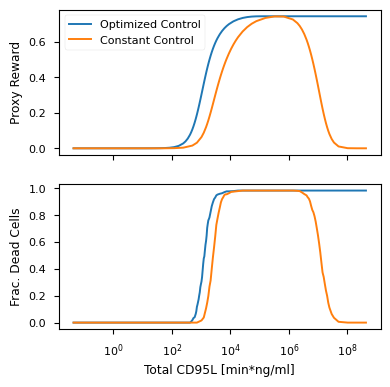

In [162]:
def sort_by_key(
    x: List[dict], sort_key: str, value_keys: str, key_map, value_map
) -> Tuple[list, list]:
    values = [
        (
            key_map(v[sort_key]),
            value_map(*[v[k] for k in value_keys])
            if isinstance(value_keys, (tuple, list))
            else value_map(v[value_keys]),
        )
        for v in x
    ]
    return sorted(values, key=lambda v: v[0])


def final_dead_cells(solution, thresholds):
    dead_cells = true_reward_fn((solution, thresholds), instantaneous=True)
    return dead_cells[-1]


def plot_scan_reward_comparison(train_extra_infos, constant_extra_infos):
    fig, ax = plt.subplots(
        2, 1, sharex=True, figsize=(plot_half_width, plot_half_width)
    )

    train_proxy = np.asarray(
        sort_by_key(
            train_extra_infos,
            "mean_conc",
            "eval_proxy_reward",
            key_map=lambda k: k[0],
            value_map=lambda v: v,
        )
    )
    constant_proxy = np.asarray(
        sort_by_key(
            constant_extra_infos,
            "mean_conc",
            "eval_proxy_reward",
            key_map=lambda k: k[0],
            value_map=lambda v: v,
        ),
    )

    train_dead = np.asarray(
        sort_by_key(
            train_extra_infos,
            "mean_conc",
            ("eval_solution", "eval_threshold"),
            key_map=lambda k: k[0],
            value_map=final_dead_cells,
        )
    )
    constant_dead = np.asarray(
        sort_by_key(
            constant_extra_infos,
            "mean_conc",
            ("eval_solution", "eval_threshold"),
            key_map=lambda k: k[0],
            value_map=final_dead_cells,
        )
    )

    ax[0].set_xscale("log")
    ax[0].set_ylabel("Proxy Reward")
    ax[0].plot(
        train_proxy[..., 0] * conversion_factor * 180,
        train_proxy[..., 1] / 500,
        label="Optimized Control",
    )
    ax[0].plot(
        constant_proxy[..., 0] * conversion_factor * 180,
        constant_proxy[..., 1] / 500,
        label="Constant Control",
    )
    ax[0].legend()

    ax[1].set_xlabel("Total CD95L [min*ng/ml]")
    ax[1].set_ylabel("Frac. Dead Cells")
    ax[1].plot(
        train_dead[..., 0] * conversion_factor * 180,
        train_dead[..., 1] / 500,
        label="Optimized Control",
    )
    ax[1].plot(
        constant_dead[..., 0] * conversion_factor * 180,
        constant_dead[..., 1] / 500,
        label="Constant Control",
    )

    plt.savefig(
        result_base_dir + "/scans/scan_reward_comparison.png", bbox_inches="tight"
    )
    plt.savefig(
        result_base_dir + "/scans/scan_reward_comparison.svg", bbox_inches="tight"
    )
    plt.show()


plot_scan_reward_comparison(cont_train_extra_infos, constant_extra_infos)

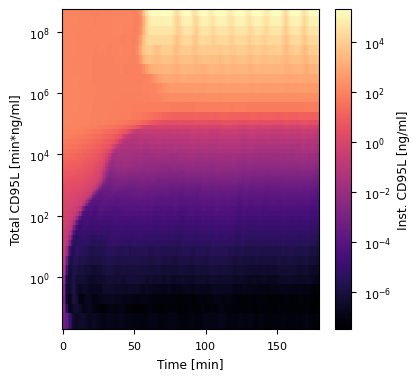

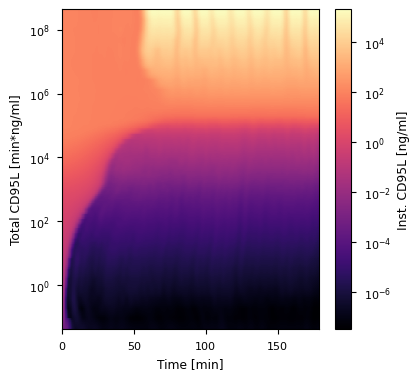

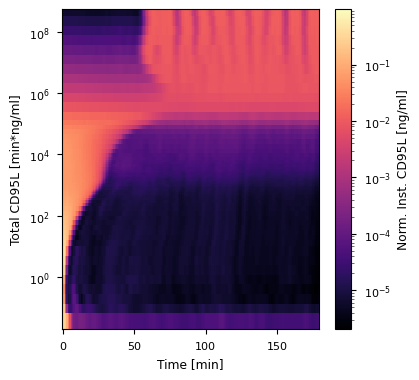

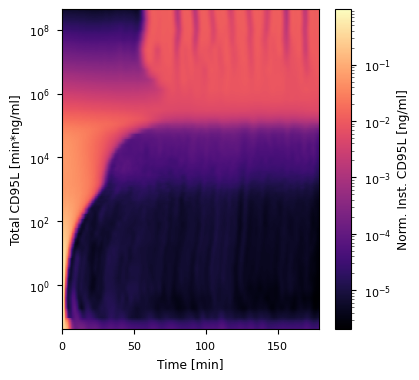

In [217]:
def plot_scan_curvegrid(extra_infos, prefix: str, with_norm: bool, use_imshow: bool):
    sorted_curves = sort_by_key(
        extra_infos,
        "mean_conc",
        "eval_control",
        key_map=lambda k: k[0],
        value_map=lambda v: v.curve.nodes,
    )

    mean_concs = np.asarray([v[0] for v in sorted_curves])
    curves = np.asarray([v[1] for v in sorted_curves])
    times = extra_infos[0]["eval_control"].curve.times

    curves = curves[:, :-1, 0]
    if with_norm:
        curves = curves / np.sum(curves, axis=1, keepdims=True)

    times = times[:-1]

    plt.figure(figsize=(plot_half_width, plot_half_width))
    plt.xlabel("Time [min]")
    plt.ylabel("Total CD95L [min*ng/ml]")

    if use_imshow:
        from scipy.interpolate import interpn

        eval_x = times
        eval_y = np.linspace(np.log(mean_concs[0]), np.log(mean_concs[-1]), len(times))
        values = interpn(
            (times, np.log(mean_concs)), curves.T, np.stack(np.meshgrid(eval_x, eval_y), axis=-1)
        )

        plt.imshow(
            values,
            cmap="magma",
            norm="log",
            aspect="auto",
            origin="lower",
            extent=[
               times[0],
               times[-1],
               np.log10(mean_concs[0] * conversion_factor * 180),
               np.log10(mean_concs[-1] * conversion_factor * 180),
            ],
        )

        ax = plt.gca()
        ax.yaxis.set_major_formatter(
           plt.FuncFormatter(lambda x, pos: f"$10^{int(x)}$")
        )
    else:
        plt.yscale("log")
        plt.pcolormesh(
            times,
            mean_concs * conversion_factor * 180,
            curves,
            shading="nearest",
            cmap="magma",
            norm="log",
        )

    cbar = plt.colorbar()
    cbar.set_label("Norm. Inst. CD95L [ng/ml]" if with_norm else "Inst. CD95L [ng/ml]")

    plt.savefig(result_base_dir + prefix + "curve_grid.png", bbox_inches="tight")
    plt.savefig(result_base_dir + prefix + "curve_grid.svg", bbox_inches="tight")
    plt.show()


plot_scan_curvegrid(cont_train_extra_infos, "/scans/continuous/", False, False)
plot_scan_curvegrid(cont_train_extra_infos, "/scans/continuous/imshow_", False, True)
plot_scan_curvegrid(cont_train_extra_infos, "/scans/continuous/norm_", True, False)
plot_scan_curvegrid(
    cont_train_extra_infos, "/scans/continuous/imshow_norm_", True, True
)

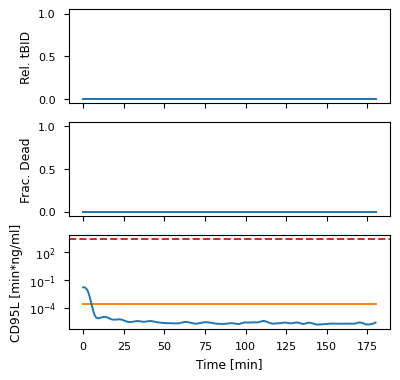

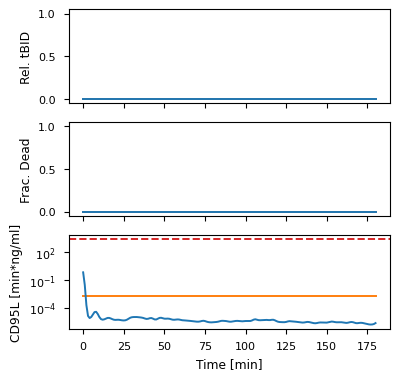

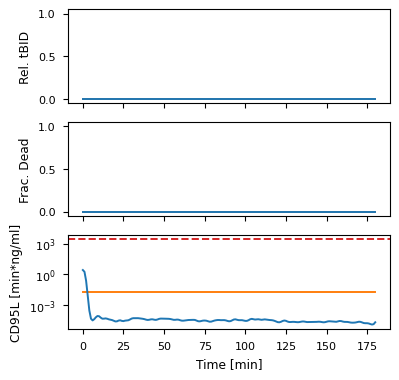

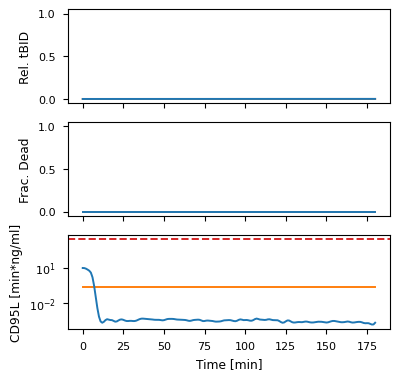

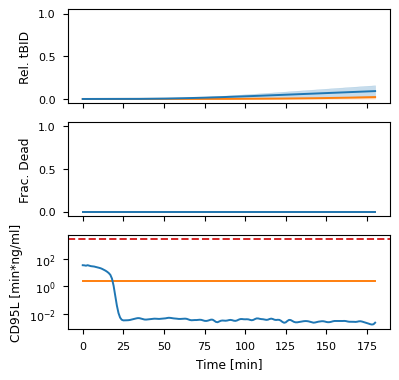

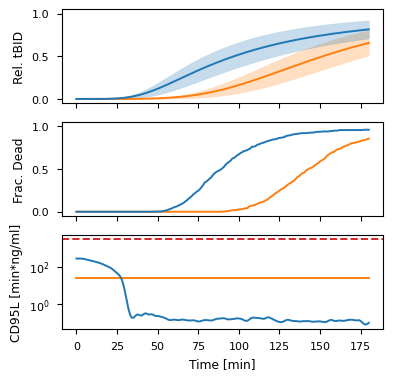

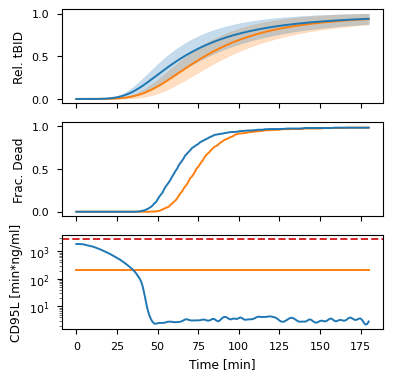

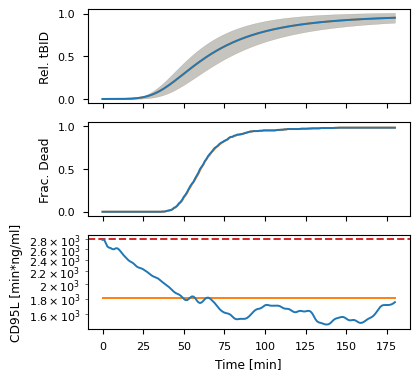

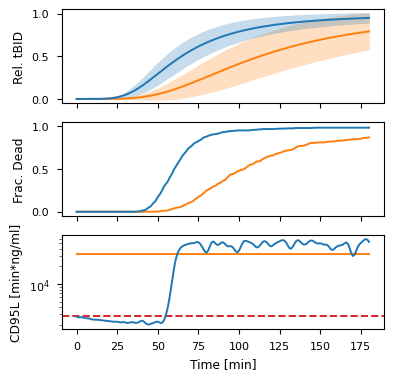

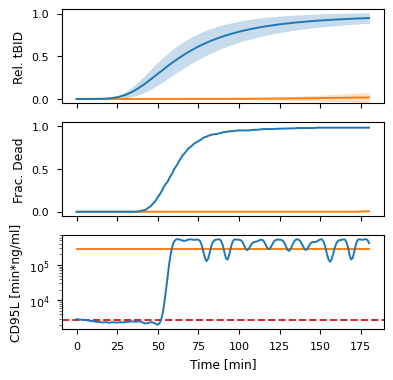

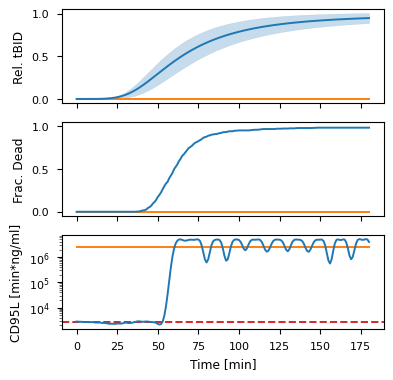

In [186]:
def plot_individual_trajectory(extra_infos, target_mean_conc, prefix: str):
    # Find closest key to target conc
    mean_concs = np.asarray([v["mean_conc"] for v in extra_infos])[:, 0]
    closest_idx = np.argmin(np.abs(mean_concs - target_mean_conc))

    closest_info = extra_infos[closest_idx]
    mean_conc = closest_info["mean_conc"]

    constant_control = controls.InterpolationCurveControl(
        nn.InterpolationCurve(
            method="step", t_start=0.0, t_end=180.0, steps=1, channels=1
        )
    )

    (constant_solution, constant_threshold), _ = evaluate_with_integral(
        constant_control,
        mean_conc,
        eval_environment,
        eval_environment_state,
    )

    fig, ax = plt.subplots(
        3, 1, sharex=True, figsize=(plot_half_width, plot_half_width)
    )

    time = constant_solution.ts

    opt_tbid_frac = tbid_fraction(closest_info["eval_solution"].ys)
    opt_tbid_frac_mean = jnp.mean(opt_tbid_frac, axis=-1)
    opt_tbid_frac_std = jnp.std(opt_tbid_frac, axis=-1)

    const_tbid_frac = tbid_fraction(constant_solution.ys)
    const_tbid_frac_mean = np.mean(const_tbid_frac, axis=-1)
    const_tbid_frac_std = jnp.std(const_tbid_frac, axis=-1)

    opt_dead_cells = true_reward_fn(
        (closest_info["eval_solution"], closest_info["eval_threshold"]),
        instantaneous=True,
    )
    const_dead_cells = true_reward_fn(
        (constant_solution, constant_threshold), instantaneous=True
    )

    # tBID
    ax[0].set_ylabel("Rel. tBID")

    ax[0].set_ylim([-0.05, 1.05])
    ax[0].fill_between(
        time,
        const_tbid_frac_mean - const_tbid_frac_std,
        const_tbid_frac_mean + const_tbid_frac_std,
        color="tab:orange",
        alpha=0.25,
    )
    ax[0].plot(time, const_tbid_frac_mean, c="tab:orange")

    ax[0].fill_between(
        time,
        opt_tbid_frac_mean - opt_tbid_frac_std,
        opt_tbid_frac_mean + opt_tbid_frac_std,
        color="tab:blue",
        alpha=0.25,
    )
    ax[0].plot(time, opt_tbid_frac_mean, c="tab:blue")

    # Number of Cells
    ax[1].set_ylabel("Frac. Dead")
    ax[1].set_ylim([-0.05, 1.05])
    ax[1].plot(time, const_dead_cells / 500, c="tab:orange")
    ax[1].plot(time, opt_dead_cells / 500, c="tab:blue")

    # Control
    ax[2].set_xlabel("Time [min]")
    ax[2].set_ylabel("CD95L [min*ng/ml]")
    ax[2].set_yscale("log")

    optimal_receptor_activation_inst_cd95l = 2795.5549439517386
    ax[2].axhline(optimal_receptor_activation_inst_cd95l, c="tab:red", linestyle="--")

    ax[2].plot(
        [time[0], time[-1]],
        [mean_conc * conversion_factor] * 2,
        c="tab:orange",
    )

    ax[2].plot(
        time,
        closest_info["eval_control"].curve.nodes * conversion_factor,
        c="tab:blue",
    )

    """
    ax[2].text(
        0.95,
        0.95,
        f"Total CD95L = {mean_conc.item() * conversion_factor * 180:.1e} min*ng/ml",
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax[2].transAxes,
        size=10,
        bbox=dict(boxstyle="square", facecolor="white", alpha=0.75),
    )
    """

    plt.savefig(
        result_base_dir + prefix + "individual_trajectory.png", bbox_inches="tight"
    )
    plt.savefig(
        result_base_dir + prefix + "individual_trajectory.svg", bbox_inches="tight"
    )

    plt.show()


for c in range(-5, 6):
    plot_individual_trajectory(cont_train_extra_infos, 10.0**c, f"/scans/continuous/individual_trajectories/{c}_")

2795.5549439517386 503199.88991131296


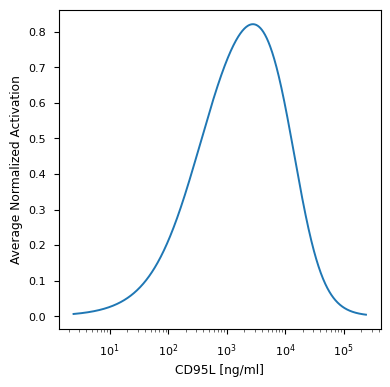

In [140]:
# CD95 response curve


def CD95act(CD95L, x):
    k = [None] * 11

    k[0] = 8.12e-4  # kon,FADD
    k[1] = 0.00567  # koff,FADD
    k[2] = 0.000492  # kon,p55
    k[3] = 0.0114  # kcl,D216
    k[4] = 4.47e-4  # kcl,D374,trans,p55
    k[5] = 0.00344  # kcl,D374,trans,p43
    k[6] = 0.0950  # kp18,inactive
    k[7] = 0.000529  # kcl,BID
    k[8] = 0.00152  # kcl,probe
    k[9] = 8.98  # KD,R
    k[10] = 15.4  # KD,L

    # Active CD95 receptors, steady state solution (in response to CD95L / control)
    CD95act = (
        x[0] ** 3
        * k[10] ** 2
        * CD95L
        / (
            (CD95L + k[10])
            * (
                x[0] ** 2 * k[10] ** 2
                + k[9] * CD95L**2
                + 2 * k[9] * k[10] * CD95L
                + k[9] * k[10] ** 2
            )
        )
    )  # CD95act

    return CD95act


ligand_moles = 10 ** np.linspace(-1, 4, 1024)
ligand_concentration = ligand_moles * conversion_factor

act = 0
for r in eval_environment_state.x0[:, 0]:
    receptor = r
    act = act + CD95act(ligand_moles, [receptor]) / receptor

act = act / eval_environment_state.x0.shape[0]

print(ligand_concentration[np.argmax(act)], ligand_concentration[np.argmax(act)]*180.0)

plt.figure(figsize=(plot_half_width, plot_half_width))
plt.xlabel("CD95L [ng/ml]")
plt.ylabel("Average Normalized Activation")
plt.xscale("log")
plt.plot(ligand_concentration, act)
plt.savefig(result_base_dir + "/receptor_activation.png", bbox_inches="tight")
plt.savefig(result_base_dir + "/receptor_activation.svg", bbox_inches="tight")
plt.show()